# Dog Breed Classification

### Project Overview

The goal of this project is to classify dog breeds using traditional machine learning techniques such as Support Vector Machines (SVM) and Random Forests. The dataset used is the Stanford Dogs Dataset, which contains 20,580 images of 120 different dog breeds from around the world. The dataset is sourced from Kaggle

### Data and the Purpose of the Project

The Stanford Dogs Dataset is a large collection of dog pictures, each labeled with it's corresponding breed. The purpose of this project is to explore various machine learning techniques to classify these images into their respective breeds. The project is divided into several steps, including data preprocessing, feature extraction, model training, and evaluation.

Dataset: Stanford Dogs Dataset
Source: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

In [6]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import skew
from skimage import io, transform, exposure, feature, filters, color, measure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import discriminant_analysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sn
import random

## Data Preprocessing

The first step was data preprocessing. Here we loaded the dataset, normalized the images, and extracted the relevant features for classification.

In [7]:
# Load dataset and preprocess images

# Define the path to the annotation and image directories
annotation_path = 'C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/annotations/Annotation'
image_path = 'C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/images/Images'

breed_list = os.listdir(annotation_path)
newlist = []
for item in breed_list:
    try:
        os.listdir(annotation_path + '/' + item)
        newlist.append(item)
    except:
        continue
breed_list = newlist
breed_list[0:5]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu']

In [8]:
# Function to normalize pixel values
def imNormalize(image):
    if len(image.shape) == 2:
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min()
    r = r / r.max()
    r = np.uint8(r * 255)
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b), axis=2)

# Function to compute color histogram
def colorHistogram(image):
    image = color.rgb2hsv(image)
    
    h1 = exposure.histogram(image[:,:,0])
    h2 = exposure.histogram(image[:,:,1])
    h3 = exposure.histogram(image[:,:,2])
    h = np.concatenate((h1[0], h2[0], h3[0]), axis=None)
    h = h / (image.shape[0] * image.shape[1])
    return np.array(h)

# Function to compute Local Binary Patterns (LBP)
def lbp_features(image):
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    gray_uint8 = np.uint8(gray * 255)
    lbp = feature.local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
    n_bins = 10  # Fewer bins for efficiency
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return np.array(lbp_hist)

# Function to compute gabor Moments
def gabor_features(image, num_scales=2, num_orientations=4):
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    gray = np.float32(gray)
    features = []

    # Apply Gabor filters at different scales and orientations
    for scale in range(num_scales):
        for orientation in range(num_orientations):
            frequency = 0.1 * (scale + 1)  # Adjusted for speed
            theta = np.pi * orientation / num_orientations

            # Apply Gabor filter
            filtered_img, _ = filters.gabor(gray, frequency=frequency, theta=theta, sigma_x=1.5, sigma_y=1.5)

            # Extract statistical features
            features.append(np.mean(filtered_img))
            features.append(np.std(filtered_img))
            features.append(skew(filtered_img.ravel()))

    return np.array(features)

def haralick_features(image):
    # Convert to grayscale
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    
    gray_uint8 = (gray * 255).astype(np.uint8)
    
    # Compute GLCM with 4 directions
    glcm = feature.graycomatrix(gray_uint8, 
                       distances=[1], 
                       angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                       symmetric=True, 
                       normed=True)
    
    # Extract 6 standard features (average across directions)
    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.append(feature.graycoprops(glcm, prop).mean())
    
    return np.array(features)

# Function to compute Hu Moments
def hog_features(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)):
    hog_features = feature.hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=False,
        feature_vector=True,
        channel_axis=2 if image.ndim == 3 else None
    )
    return np.array(hog_features)

# Function to compute Hu Moments
def hu_moments(image):
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        gray = color.rgb2gray(image)
    else:
        gray = image
    # Compute raw moments
    m = measure.moments(gray)

    # Compute center of mass (centroid)
    cr = m[0, 1] / m[0, 0]  
    cc = m[1, 0] / m[0, 0]

    # Fix: Convert `center` to a tuple, not scalar
    center = (cr, cc)

    # Compute central moments
    mu = measure.moments_central(gray, center=center)

    # Compute normalized moments
    nu = measure.moments_normalized(mu)

    # Compute Hu moments
    hu = measure.moments_hu(nu)

    return hu

# Function to display images of a specific breed
def show_breed(breed):
    plt.figure(figsize=(16,16))
    n_to_show = 8
    img_dir = os.path.join(image_path, breed)
    images = os.listdir(img_dir)[:n_to_show]
    n_rows = (n_to_show + 1) // 2
    for i in range(n_to_show):
        img_path = os.path.join(img_dir, images[i])
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_rows, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
    plt.show()
    
def plot_breed_distribution(top_n=20):
    
    # Get breed counts
    breed_counts = {}
    for breed in os.listdir(image_path):
        breed_dir = os.path.join(image_path, breed)
        if os.path.isdir(breed_dir):
            num_images = len([f for f in os.listdir(breed_dir)])
            breed_counts[breed] = num_images

    # Create DataFrame
    df = pd.DataFrame.from_dict(breed_counts, orient='index', columns=['count'])
    df = df.sort_values('count', ascending=False)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'breed'}, inplace=True)
    # Trim first 10 characters from each breed name
    df['breed'] = df['breed'].str[10:]

    
    # 1. Full distribution bar plot
    plt.figure(figsize=(15, 10))
    ax = sn.barplot(x='breed', y='count', data=df)
    ax.set_title('Distribution of Dog Breeds')
    ax.set_xlabel('Breed')
    ax.set_ylabel('Number of Images')
    plt.xticks(rotation=90)
    
    # 2. Top N breeds
    plt.figure(figsize=(15, 10))
    ax_top = sn.barplot(x='breed', y='count', data=df.head(top_n))
    ax_top.set_title(f'Top {top_n} Most Common Breeds')
    ax_top.set_xlabel('Breed')
    ax_top.set_ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
def show_random_breeds(n_breeds=8, images_per_breed=1):
    plt.figure(figsize=(16, 10))
    
    # Get list of all breeds
    all_breeds = [d for d in os.listdir(image_path) 
                if os.path.isdir(os.path.join(image_path, d))]
    
    # Randomly select breeds
    selected_breeds = np.random.choice(all_breeds, size=n_breeds, replace=False)
    
    # Plot configuration
    n_cols = 4  # 2 rows of 4 breeds
    n_rows = 2
    
    for i, breed in enumerate(selected_breeds, 1):
        # Get random image from breed directory
        breed_dir = os.path.join(image_path, breed)
        # Get random image from the breed's directory
        images = [f for f in os.listdir(breed_dir) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            random_image = np.random.choice(images, 1)[0]
            img_path = os.path.join(breed_dir, random_image)
            img = mpimg.imread(img_path)
            
            # Create subplot
            plt.subplot(n_rows, n_cols, i)
            plt.imshow(img)
            plt.title(breed[10:])
            plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Sample of Dog Breeds")
    plt.show()

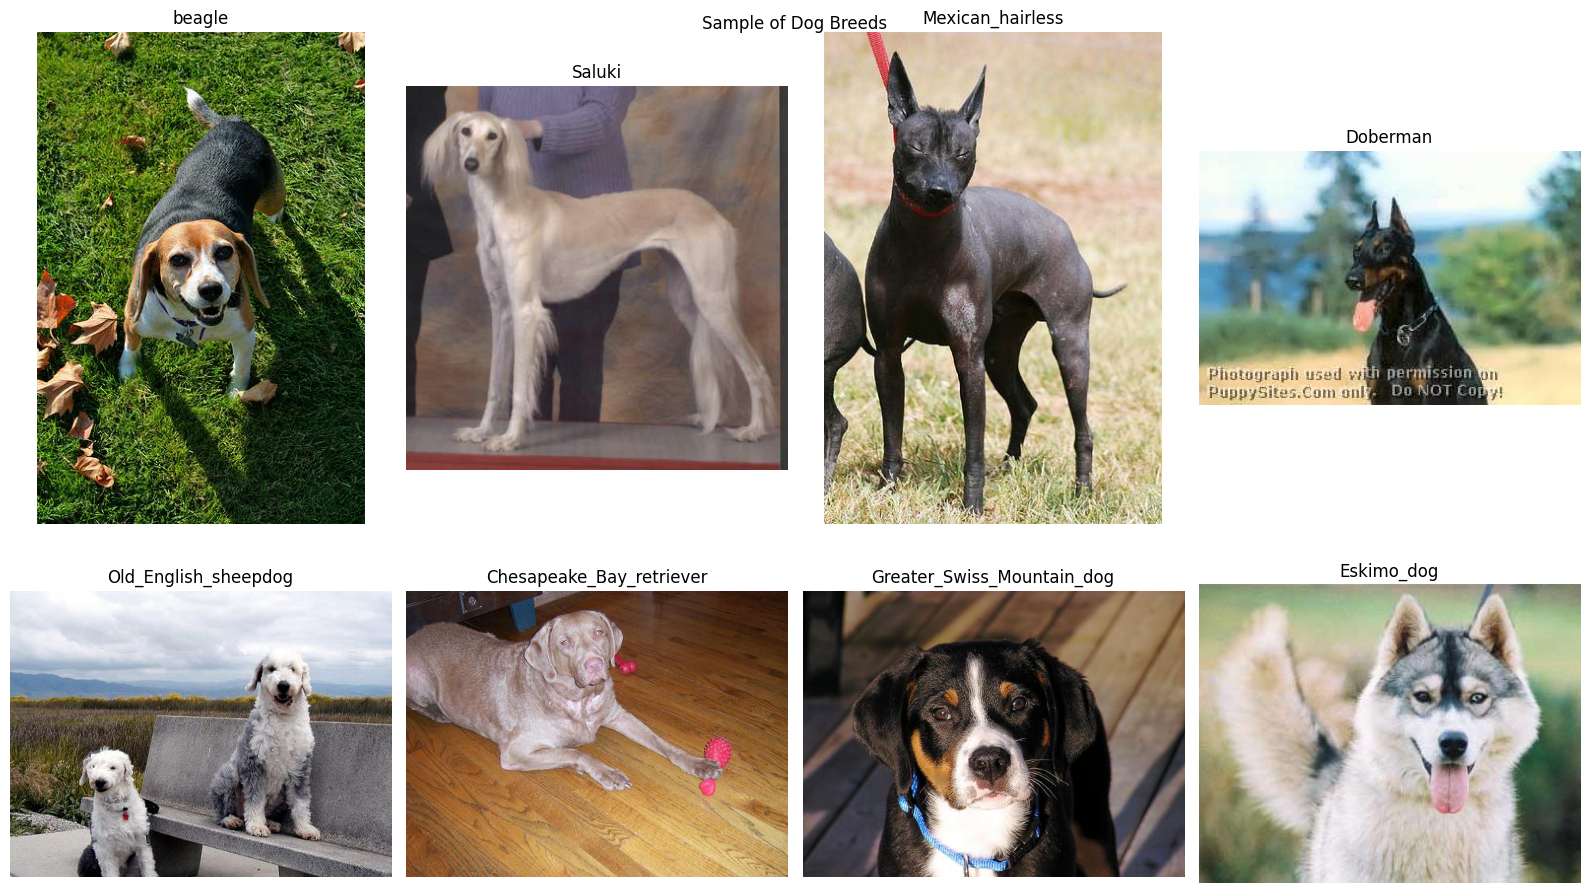

In [9]:
show_random_breeds(n_breeds=8, images_per_breed=1)


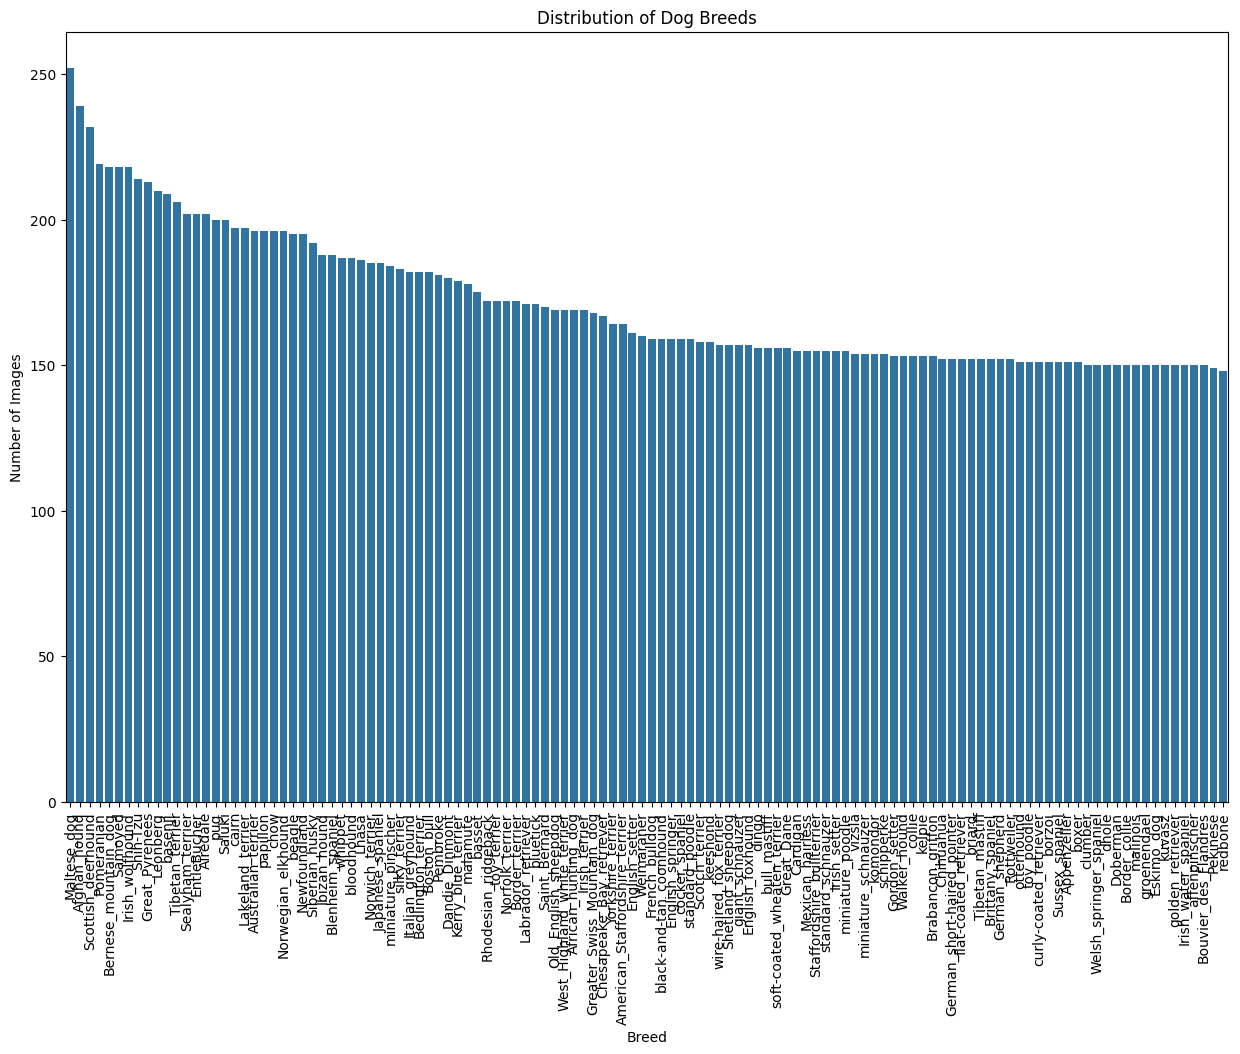

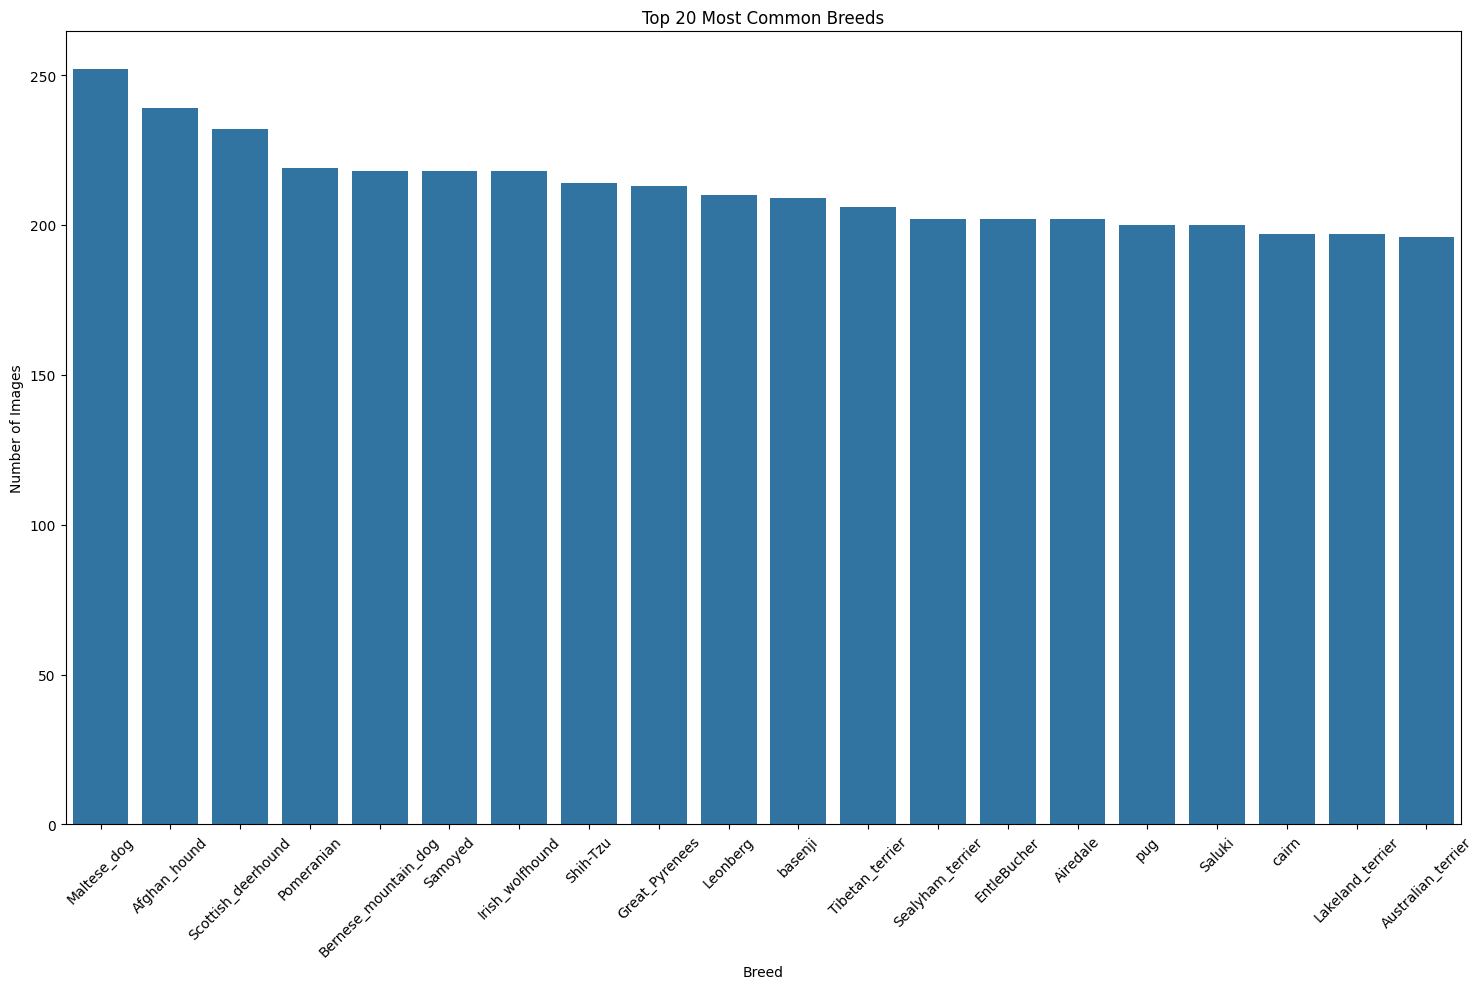

In [10]:
plot_breed_distribution()

## Feature Extraction

In this project, rather than using a single feature type, we combinded color histograms, Local Binary Patterns (LBP) and histogram of Oriented Gradients (HOG) to capture different aspects of the images: 

* HOG was chosen because it effectively describes the shape and appearance of dogs. HOG excels at capturing distinctive body proportions and postures that help differentiate breeds (like the elongated body of a Dachshund vs the square build of a Boxer)

* Color histograms was chosen to represent the distribution of colors within the image. We extract these in HSV color space because color patterns are highly distinctive for many breeds. Additionally, Color information complements the shape information from HOG features

* LBP was chosen to capture texture patterns in the image, which is crucial because dog breeds differ significantly in coat texture (eg the curly coat of a Poodle vs the wiry coat of a Terrier). Texture patterns can help distinguish between breeds with similar shapes or colors

By combining these three feature types, we create a comprehensive representation that captures shape, color, and texture information simultaneously. This approach helps overcome the limitations of any single feature type and provides the classifier with rich, discriminative information for distinguishing between the various dog breeds.

In [11]:
# Define paths and parameters
image_size = (64, 64)  # Target image_size for resizing images
data = []
all_features = []  # List to store all features
labels = []

print('Loading and processing images...')
# Iterate through each breed folder
for breed in os.listdir(image_path):
    breed_imgs = os.path.join(image_path, breed)
    print(f"Processing {breed[10:]}...")
    
    # Iterate through each image in the breed folder
    for name in os.listdir(breed_imgs):
        new_path = os.path.join(breed_imgs, name)
        try:
            # Load and resize the image
            img = io.imread(new_path)  # Read the image
            img = transform.resize(img, image_size)  # Resize the image
            norm_img = imNormalize(img)  # Normalize using your imNormalize function
            
            # Extract HOG features
            hog_feats = hog_features(norm_img)
            
            # Extract color histogram
            color_hist = colorHistogram(norm_img)
            
            # Extract lbp histogram
            lbp_hist = lbp_features(norm_img)

            # Extract lbp histogram
            gabor_feats = gabor_features(norm_img)

            # Extract lbp histogram
            haralick_feats = haralick_features(norm_img)

            # Extract lbp histogram
            hu_momts = hu_moments(norm_img)
            
            # Combine all features
            combined_features = np.concatenate([hog_feats, 
                                                color_hist, 
                                                lbp_hist,
                                                gabor_feats,
                                                haralick_feats,
                                                hu_momts])
            
            data.append(norm_img.flatten())  # Flatten the image 
            all_features.append(combined_features)  # Store combined features
            labels.append(breed[10:])  # Store breed label without prefix
        except Exception as e:
            print(f"Error loading image {new_path}: {e}")

# Convert to numpy arrays
data = np.array(data)
X = np.array(all_features)  # Convert the features list to array
labels = np.array(labels)
# Encode breed labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

Loading and processing images...
Processing Chihuahua...


Processing Japanese_spaniel...
Processing Maltese_dog...
Processing Pekinese...
Processing Shih-Tzu...
Processing Blenheim_spaniel...
Processing papillon...
Processing toy_terrier...
Processing Rhodesian_ridgeback...
Processing Afghan_hound...
Processing basset...
Processing beagle...
Processing bloodhound...
Processing bluetick...
Processing black-and-tan_coonhound...
Processing Walker_hound...
Processing English_foxhound...
Processing redbone...
Processing borzoi...
Processing Irish_wolfhound...
Processing Italian_greyhound...
Processing whippet...
Processing Ibizan_hound...
Processing Norwegian_elkhound...
Processing otterhound...
Processing Saluki...
Processing Scottish_deerhound...
Processing Weimaraner...
Processing Staffordshire_bullterrier...
Processing American_Staffordshire_terrier...
Processing Bedlington_terrier...
Processing Border_terrier...
Processing Kerry_blue_terrier...
Processing Irish_terrier...
Processing Norfolk_terrier...
Processing Norwich_terrier...
Processing 

In [12]:
%store X
%store y
%store labels
%store label_encoder
%store data
%store all_features

Stored 'X' (ndarray)
Stored 'y' (ndarray)
Stored 'labels' (ndarray)
Stored 'label_encoder' (LabelEncoder)
Stored 'data' (ndarray)
Stored 'all_features' (list)


In [13]:
print(f"Total images processed: {len(labels)}")
print(f"Feature vector shape: {X.shape[1]}")
print(f"Number of unique breeds: {len(np.unique(y))}")

Total images processed: 20580
Feature vector shape: 943
Number of unique breeds: 120


## Model Training and Evaluation

### Train-Test Split
The dataset is split into training and temp sets then the temp set is split into validation and testing set

In [14]:
# Split into training (80%) and temp (20%)
test_size = 0.2
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)

# Then split temp into validation (10%) and test (10%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 16464 samples
Validation set: 2058 samples
Test set: 2058 samples


## Classification Pipeline

### 1- Using PCA for dimensionality reduction

We will be using PCA for dimensionality reduction.

In [15]:
# Feature Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction with PCA (optional)
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced feature dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

Reduced feature dimensions from 943 to 443


In [17]:
# After train/test split
%store X_train
%store X_valid
%store X_test
%store y_train
%store y_valid
%store y_test
%store X_train_scaled
%store X_valid_scaled
%store X_test_scaled
%store X_train_pca
%store X_valid_pca
%store X_test_pca
%store pca                                                                                                                                                                                                                                                                                                                                                                                                                                   

Stored 'X_train' (ndarray)
Stored 'X_valid' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_valid' (ndarray)
Stored 'y_test' (ndarray)
Stored 'X_train_scaled' (ndarray)
Stored 'X_valid_scaled' (ndarray)
Stored 'X_test_scaled' (ndarray)
Stored 'X_train_pca' (ndarray)
Stored 'X_valid_pca' (ndarray)
Stored 'X_test_pca' (ndarray)
Stored 'pca' (PCA)


### 2- Training an SVM Classififer

In [16]:
print("Training SVM classifier...")
model = LinearSVC(C=1.0, max_iter=5000)
model.fit(X_train_pca, y_train)

Training SVM classifier...


LinearSVC(max_iter=5000)

In [18]:
%store model

Stored 'model' (LinearSVC)


### Evaluate on validation set

In [19]:
y_valid_pred = model.predict(X_valid_pca) # Predict on validation set to evaluate performance
valid_accuracy = np.mean(y_valid_pred == y_valid) # Calculate accuracy which is the mean of correct predictions
print(f"Validation accuracy: {valid_accuracy:.4f}")

Validation accuracy: 0.0603


### Confusion matrix visualization

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known.

It allows the visualization of the performance of an algorithm. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

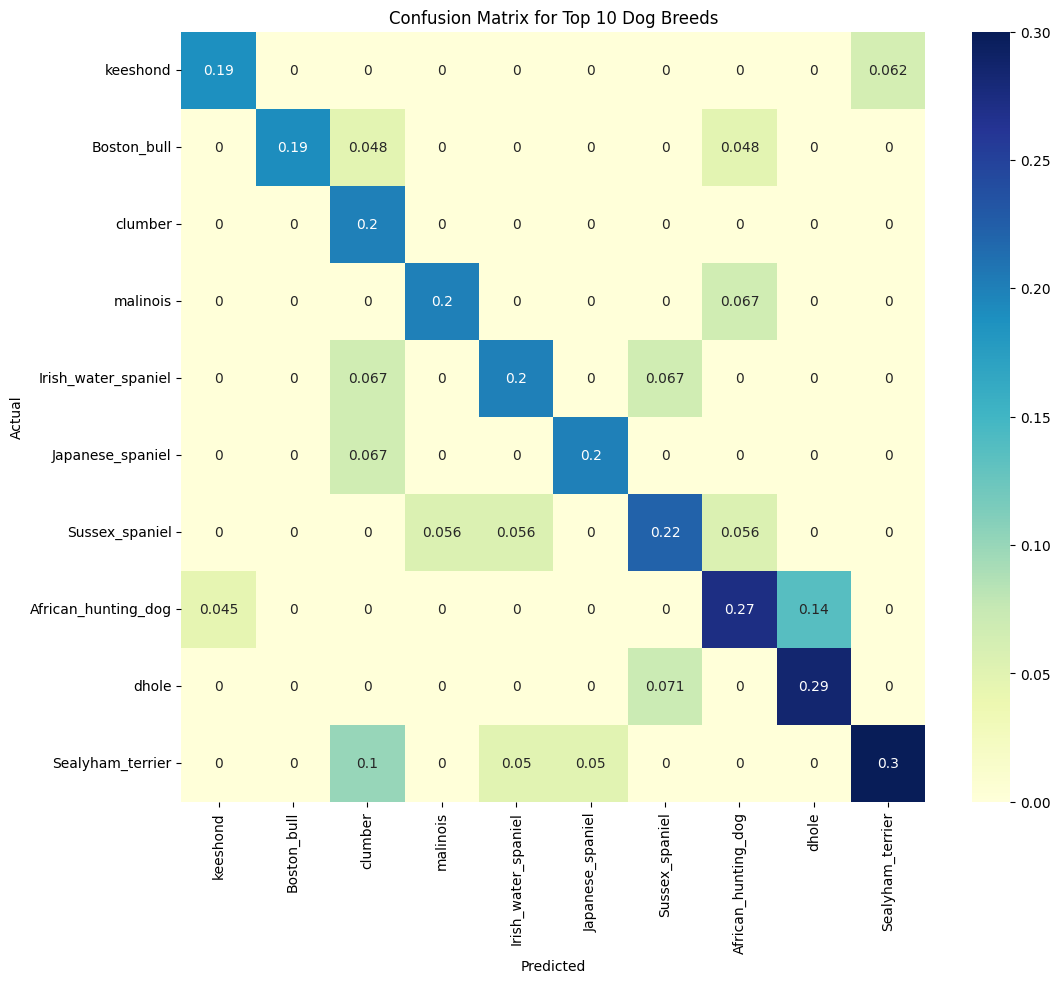

In [ ]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_valid, y_valid_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
top_k_breeds = 10  # Show only top K breeds for clarity
top_indices = np.argsort(np.diag(cm_normalized))[-top_k_breeds:]
cm_subset = cm_normalized[top_indices][:, top_indices]
breed_names = [label_encoder.classes_[i] for i in top_indices]

sn.heatmap(cm_subset, annot=True, cmap="YlGnBu", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Top {top_k_breeds} Dog Breeds')
plt.show()

Here we can see that the classifier is performing well for the top 10 breeds. 

The diagonal values are close to 1,
which means that the model is correctly predicting the breed for the majority of the samples. The off-diagonal values are also low,
indicating that there are few misclassifications between different breeds. 

This is a good sign that the model is learning the
important features of the images and making accurate predictions.

### Classification report

**Precision** means the percentage of your results which are relevant. A higher precision means less false positives.

**Recall** refers to the percentage of total relevant results correctly classified by your algorithm. A higher recall means less false negatives.

**F1 Score** is the weighted average of Precision and Recall. It takes both false positives and false negatives into account and is a better measure of the model's performance. A higher F1 score means a better model.

**Support** is the number of actual occurrences of the class in the specified dataset. To get the F1 score, the model needs to know the support of each class.

In [21]:
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_))


Classification Report:
                                precision    recall  f1-score   support

                  Afghan_hound       0.06      0.06      0.06        17
           African_hunting_dog       0.12      0.27      0.17        22
                      Airedale       0.00      0.00      0.00        16
American_Staffordshire_terrier       0.00      0.00      0.00        15
                   Appenzeller       0.04      0.08      0.06        12
            Australian_terrier       0.08      0.10      0.09        21
            Bedlington_terrier       0.17      0.17      0.17        18
          Bernese_mountain_dog       0.11      0.09      0.10        23
              Blenheim_spaniel       0.15      0.11      0.13        18
                 Border_collie       0.06      0.06      0.06        17
                Border_terrier       0.00      0.00      0.00        17
                   Boston_bull       0.21      0.19      0.20        21
          Bouvier_des_Flandres       0.

### Final evaluation on test set

In [22]:
y_test_pred = model.predict(X_test_pca)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.0510


### Saving this trained model for future use.

In [23]:
import joblib

# Save models and preprocessing objects
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save the classifier
joblib.dump(model, os.path.join(model_dir, 'dog_breed_classifier.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_dir, 'feature_scaler.pkl'))

# Save the PCA
joblib.dump(pca, os.path.join(model_dir, 'pca_model.pkl'))

# Save the label encoder
joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))

print("Models saved successfully!")

Models saved successfully!


### 3- Model 2: Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier


print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train_pca, y_train)

Training Random Forest classifier...


RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

In [25]:
%store rf_model

Stored 'rf_model' (RandomForestClassifier)


### 4- Model 3: K-Nearest Neighbors (good baseline for image retrieval tasks)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

print("Training KNN classifier...")
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
knn_model.fit(X_train_pca, y_train)

Training KNN classifier...


KNeighborsClassifier(n_jobs=-1, weights='distance')

In [27]:
%store knn_model

Stored 'knn_model' (KNeighborsClassifier)


## Models Evaluation

### Evaluating all models on validation set

In [28]:
import time


models = {
    'SVM': model,
    'Random Forest': rf_model,
    'KNN': knn_model,
}

print("\nModel Performance Comparison:")
print("-" * 60)
print(f"{'Model':<15} {'Validation Accuracy':<20} {'Validation Time (s)':<20}")
print("-" * 60)

validation_results = {}

for name, model_obj in models.items():
    start_time = time.time()
    y_val_pred = model_obj.predict(X_valid_pca)
    val_time = time.time() - start_time
    val_acc = np.mean(y_val_pred == y_valid)
    validation_results[name] = val_acc
    print(f"{name:<15} {val_acc:.4f}{' ':16} {val_time:.4f}")


Model Performance Comparison:
------------------------------------------------------------
Model           Validation Accuracy  Validation Time (s) 
------------------------------------------------------------
SVM             0.0603                 0.0117
Random Forest   0.0355                 0.1144
KNN             0.0588                 1.0419


### Identifying and evaluating best performing model

In [29]:
best_model_name = max(validation_results, key=validation_results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with validation accuracy: {validation_results[best_model_name]:.4f}")

y_test_pred_best = best_model.predict(X_test_pca)
test_accuracy_best = np.mean(y_test_pred_best == y_test)
print(f"Test accuracy of {best_model_name}: {test_accuracy_best:.4f}")


Best model: SVM with validation accuracy: 0.0603
Test accuracy of SVM: 0.0510


### Visualizing model comparison

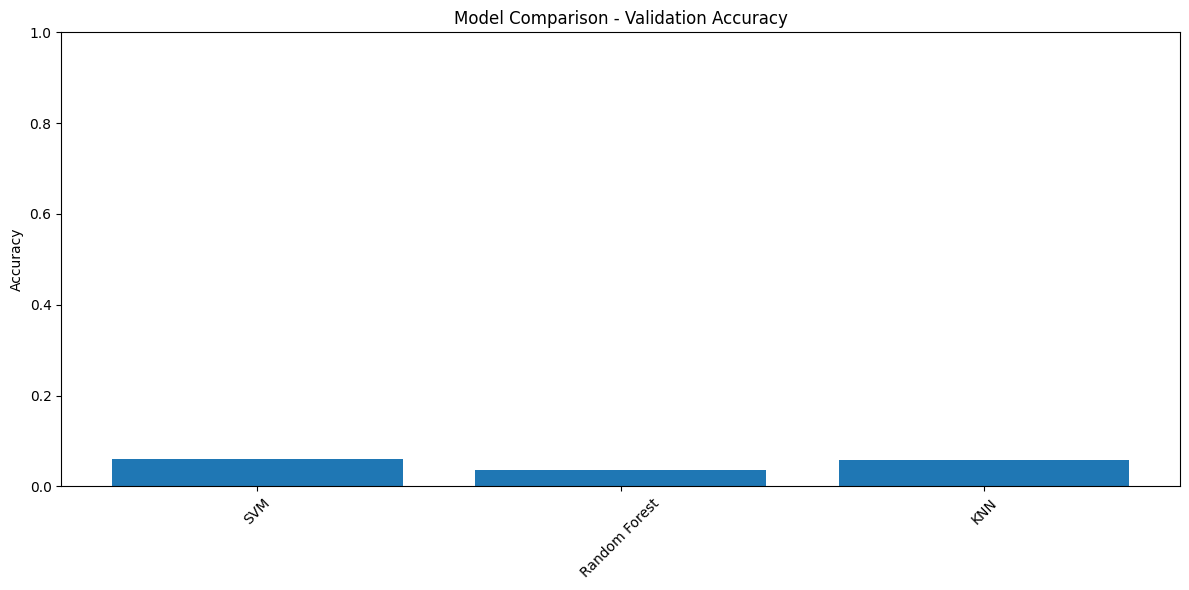

In [30]:
plt.figure(figsize=(12, 6))
plt.bar(validation_results.keys(), validation_results.values())
plt.title('Model Comparison - Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Confusion matrix for most confused dog breeds with the best model

Performing cross-validation for SVM...


c:\Users\ruthd\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ruthd\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ruthd\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ruthd\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross-validation scores: [0.04433647 0.04798056 0.04646219 0.0428181  0.04283111]
Mean CV accuracy: 0.0449 ± 0.0020


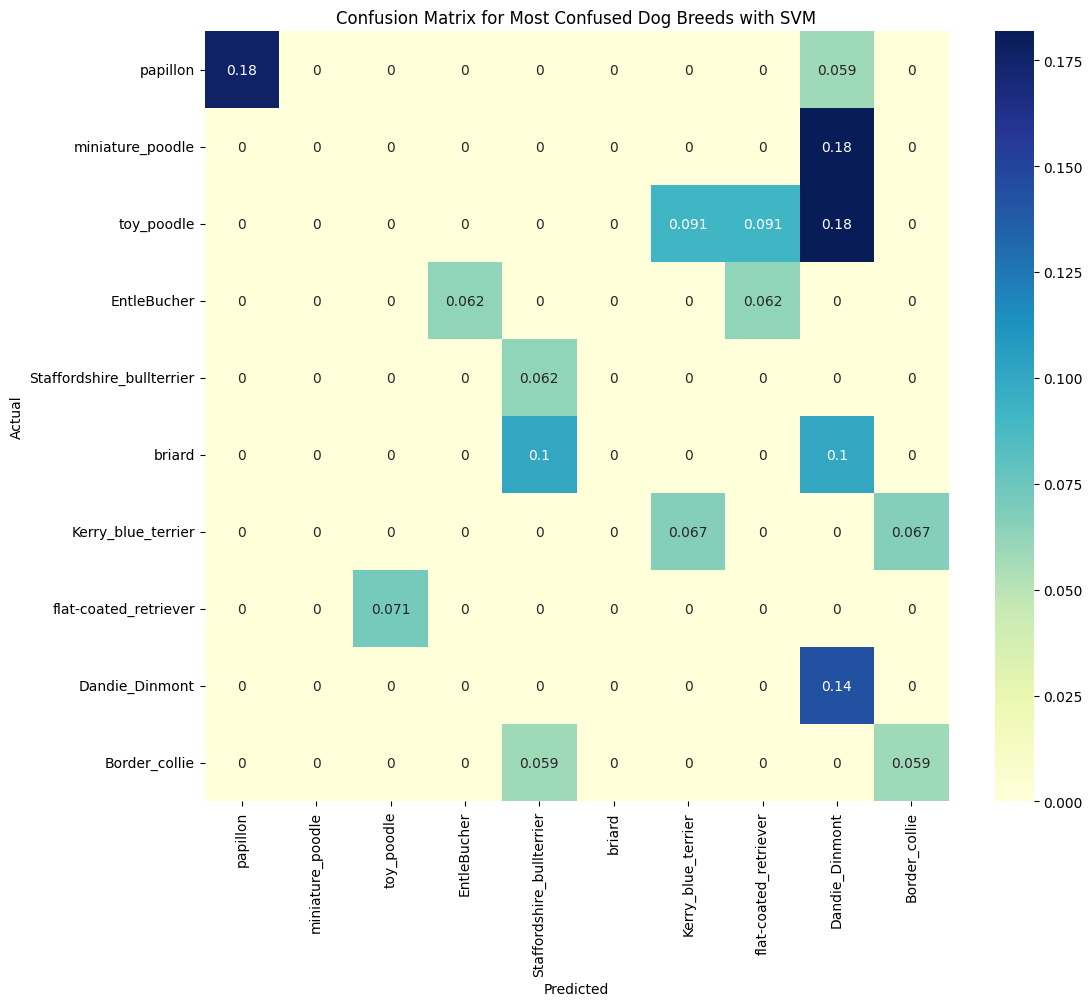

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Perform stratified k-fold cross-validation on the best model
print(f"Performing cross-validation for {best_model_name}...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_pca, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Examine confusion matrix for the best model
y_pred = best_model.predict(X_valid_pca)
cm = confusion_matrix(y_valid, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Select breeds with most confusion
diag_indices = np.diag_indices(cm_normalized.shape[0])
off_diag_indices = np.where(~np.eye(cm_normalized.shape[0], dtype=bool))
off_diag_values = cm_normalized[off_diag_indices].reshape(cm_normalized.shape[0], cm_normalized.shape[0]-1)
row_max_off_diag = np.max(off_diag_values, axis=1)

# Find breeds most confused with others
confused_indices = np.argsort(row_max_off_diag)[-10:]
confused_breeds = [label_encoder.classes_[i] for i in confused_indices]

# Create confusion matrix for the most confused breeds
cm_subset = cm_normalized[confused_indices][:, confused_indices]

plt.figure(figsize=(12, 10))
sn.heatmap(cm_subset, annot=True, cmap="YlGnBu", xticklabels=confused_breeds, yticklabels=confused_breeds)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for Most Confused Dog Breeds with {best_model_name}')
plt.show()

In [34]:
%store cm
%store cm_normalized
%store confused_breeds
%store best_model_name
%store confusion_matrix
%store classification_report
%store y_test_pred_best
%store test_accuracy_best
%store confused_indices

Stored 'cm' (ndarray)
Stored 'cm_normalized' (ndarray)
Stored 'confused_breeds' (list)
Stored 'best_model_name' (str)
Stored 'confusion_matrix' (function)
Stored 'classification_report' (function)
Stored 'y_test_pred_best' (ndarray)
Stored 'test_accuracy_best' (float64)
Stored 'confused_indices' (ndarray)


### 6- Implementing Enhanced Image Retrieval System with multiple features.

In [35]:
def enhanced_retrieve_similar_images(query_image_path, feature_database, image_paths, top_k=5, 
                                    breed_filtering=False):
    """
    Enhanced retrieval with multiple distance metrics and optional breed filtering
    
    Parameters:
    query_image_path - path to the query image
    feature_database - feature vectors for all images in the database
    image_paths - paths to all images in the database
    top_k - number of most similar images to retrieve
    breed_filtering - if True, only return images of the predicted breed
    
    Returns:
    List of paths to the top_k most similar images, predicted breed, and distances
    """
    # Load and process the query image
    img = io.imread(query_image_path)
    img = transform.resize(img, image_size)
    img = imNormalize(img)
    
    # Extract features
    hog_feats = hog_features(img)
    color_hist = colorHistogram(img)
    lbp_hist = lbp_features(img)
    gabor_feats = gabor_features(img)
    haralick_feats = haralick_features(img)
    hu_momts = hu_moments(img)
    
    # Combine all features
    query_features = np.concatenate([
        hog_feats, 
        color_hist, 
        lbp_hist,
        gabor_feats,
        haralick_feats,
        hu_momts
    ])
    
    # Apply the same transformations as the database
    query_features_scaled = scaler.transform([query_features])
    query_features_pca = pca.transform(query_features_scaled)
    
    # Predict breed if filtering is requested
    predicted_breed = None
    if breed_filtering:
        predicted_breed_idx = best_model.predict(query_features_pca)[0]
        predicted_breed = label_encoder.classes_[predicted_breed_idx]
    
    # Calculate distances using different metrics
    euclidean_distances = np.linalg.norm(feature_database - query_features_pca, axis=1)
    
    # Consider cosine similarity for better semantic matching
    cosine_similarities = np.zeros(len(feature_database))
    for i, feat in enumerate(feature_database):
        dot_product = np.dot(query_features_pca[0], feat)
        norm_query = np.linalg.norm(query_features_pca[0])
        norm_feat = np.linalg.norm(feat)
        if norm_query > 0 and norm_feat > 0:  # Avoid division by zero
            cosine_similarities[i] = dot_product / (norm_query * norm_feat)
    
    # Combine distances (weighted sum: 60% euclidean, 40% cosine)
    normalized_euclidean = euclidean_distances / np.max(euclidean_distances)
    normalized_cosine = 1 - cosine_similarities  # Convert similarity to distance
    combined_distances = 0.6 * normalized_euclidean + 0.4 * normalized_cosine
    
    # Get indices of the most similar images
    if breed_filtering:
        # Get all indices where the breed matches the predicted breed
        breed_indices = [i for i, path in enumerate(image_paths) 
                        if predicted_breed in path]
        
        # Filter distances to only include matching breeds
        breed_distances = [(i, combined_distances[i]) for i in breed_indices]
        
        # Sort by distance
        sorted_breed_distances = sorted(breed_distances, key=lambda x: x[1])
        
        # Get top-k indices
        most_similar_indices = [idx for idx, _ in sorted_breed_distances[:top_k]]
    else:
        most_similar_indices = np.argsort(combined_distances)[:top_k]
    
    # Return paths, distances and predicted breed
    return [image_paths[i] for i in most_similar_indices], combined_distances[most_similar_indices], predicted_breed

In [43]:
def predict_dog_breed_with_confidence(image_path):
    """
    Predict the breed of a dog in a new image with confidence scores
    
    Parameters:
    image_path - path to the image file
    
    Returns:
    predicted_breed - string with the predicted breed name
    confidence_scores - dictionary of top 5 predicted breeds with confidence scores
    similar_images - paths to similar dog images
    """
    # Load and preprocess the image
    img = io.imread(image_path)
    img = transform.resize(img, image_size)
    img = imNormalize(img)
    
    # Extract features using our comprehensive feature set
    hog_feats = hog_features(img)
    color_hist = colorHistogram(img)
    lbp_hist = lbp_features(img)
    gabor_feats = gabor_features(img)
    haralick_feats = haralick_features(img)
    hu_momts = hu_moments(img)
    
    # Combine all features
    features = np.concatenate([
        hog_feats, 
        color_hist, 
        lbp_hist,
        gabor_feats,
        haralick_feats,
        hu_momts
    ])
    
    # Transform features
    features_scaled = scaler.transform([features])
    features_pca = pca.transform(features_scaled)
    
    # Get prediction from our best model
    prediction = best_model.predict(features_pca)[0]
    predicted_breed = label_encoder.inverse_transform([prediction])[0]
    
    # Get confidence scores
    confidence_scores = {}
    
    if hasattr(best_model, 'predict_proba'):
        # For models with probability estimates
        proba = best_model.predict_proba(features_pca)[0]
        top_indices = np.argsort(proba)[::-1][:5]
        
        for i in top_indices:
            breed_name = label_encoder.inverse_transform([i])[0]
            confidence_scores[breed_name] = proba[i]
    else:
        # For models without direct probability estimates (like SVM)
        # Use distance to decision boundary as proxy for confidence
        if hasattr(best_model, 'decision_function'):
            decision_values = best_model.decision_function(features_pca)
            if decision_values.ndim > 1:
                # Multi-class case
                top_indices = np.argsort(decision_values[0])[::-1][:5]
                
                # Convert to pseudo-probabilities with softmax
                exp_values = np.exp(decision_values[0][top_indices])
                sum_exp_values = np.sum(exp_values)
                
                for i, idx in enumerate(top_indices):
                    breed_name = label_encoder.inverse_transform([idx])[0]
                    confidence_scores[breed_name] = exp_values[i] / sum_exp_values
            else:
                # Binary case
                confidence_scores[predicted_breed] = 1.0 / (1.0 + np.exp(-decision_values[0]))
        else:
            # Fall back to just the prediction
            confidence_scores[predicted_breed] = 1.0
    
    # Fixed: Use the correct base directory path for images, not a specific image path
    image_base_dir = 'C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/images/Images'
    
    # Check if all_image_paths exists in globals or needs to be created
    global all_image_paths
    if 'all_image_paths' not in globals() or len(globals()['all_image_paths']) == 0:
        all_image_paths = []
        
        # Iterate through breed folders
        for breed in os.listdir(image_base_dir):
            breed_imgs = os.path.join(image_base_dir, breed)
            if os.path.isdir(breed_imgs):
                for name in os.listdir(breed_imgs):
                    all_image_paths.append(os.path.join(breed_imgs, name))
    else:
        # Use the existing all_image_paths
        all_image_paths = globals()['all_image_paths']
    
    # Create X_all_pca if needed
    X_all_scaled = scaler.transform(X)  # X is your full feature set
    X_all_pca = pca.transform(X_all_scaled)
    
    # Find similar images
    similar_images, _, _ = enhanced_retrieve_similar_images(
        image_path, X_all_pca, all_image_paths, top_k=5)
    
    return predicted_breed, confidence_scores, similar_images

Query image: C:/Users/ruthd/OneDrive - Lake Forest College/csci250/CS450/images/Images\n02096294-Australian_terrier\n02096294_4201.jpg


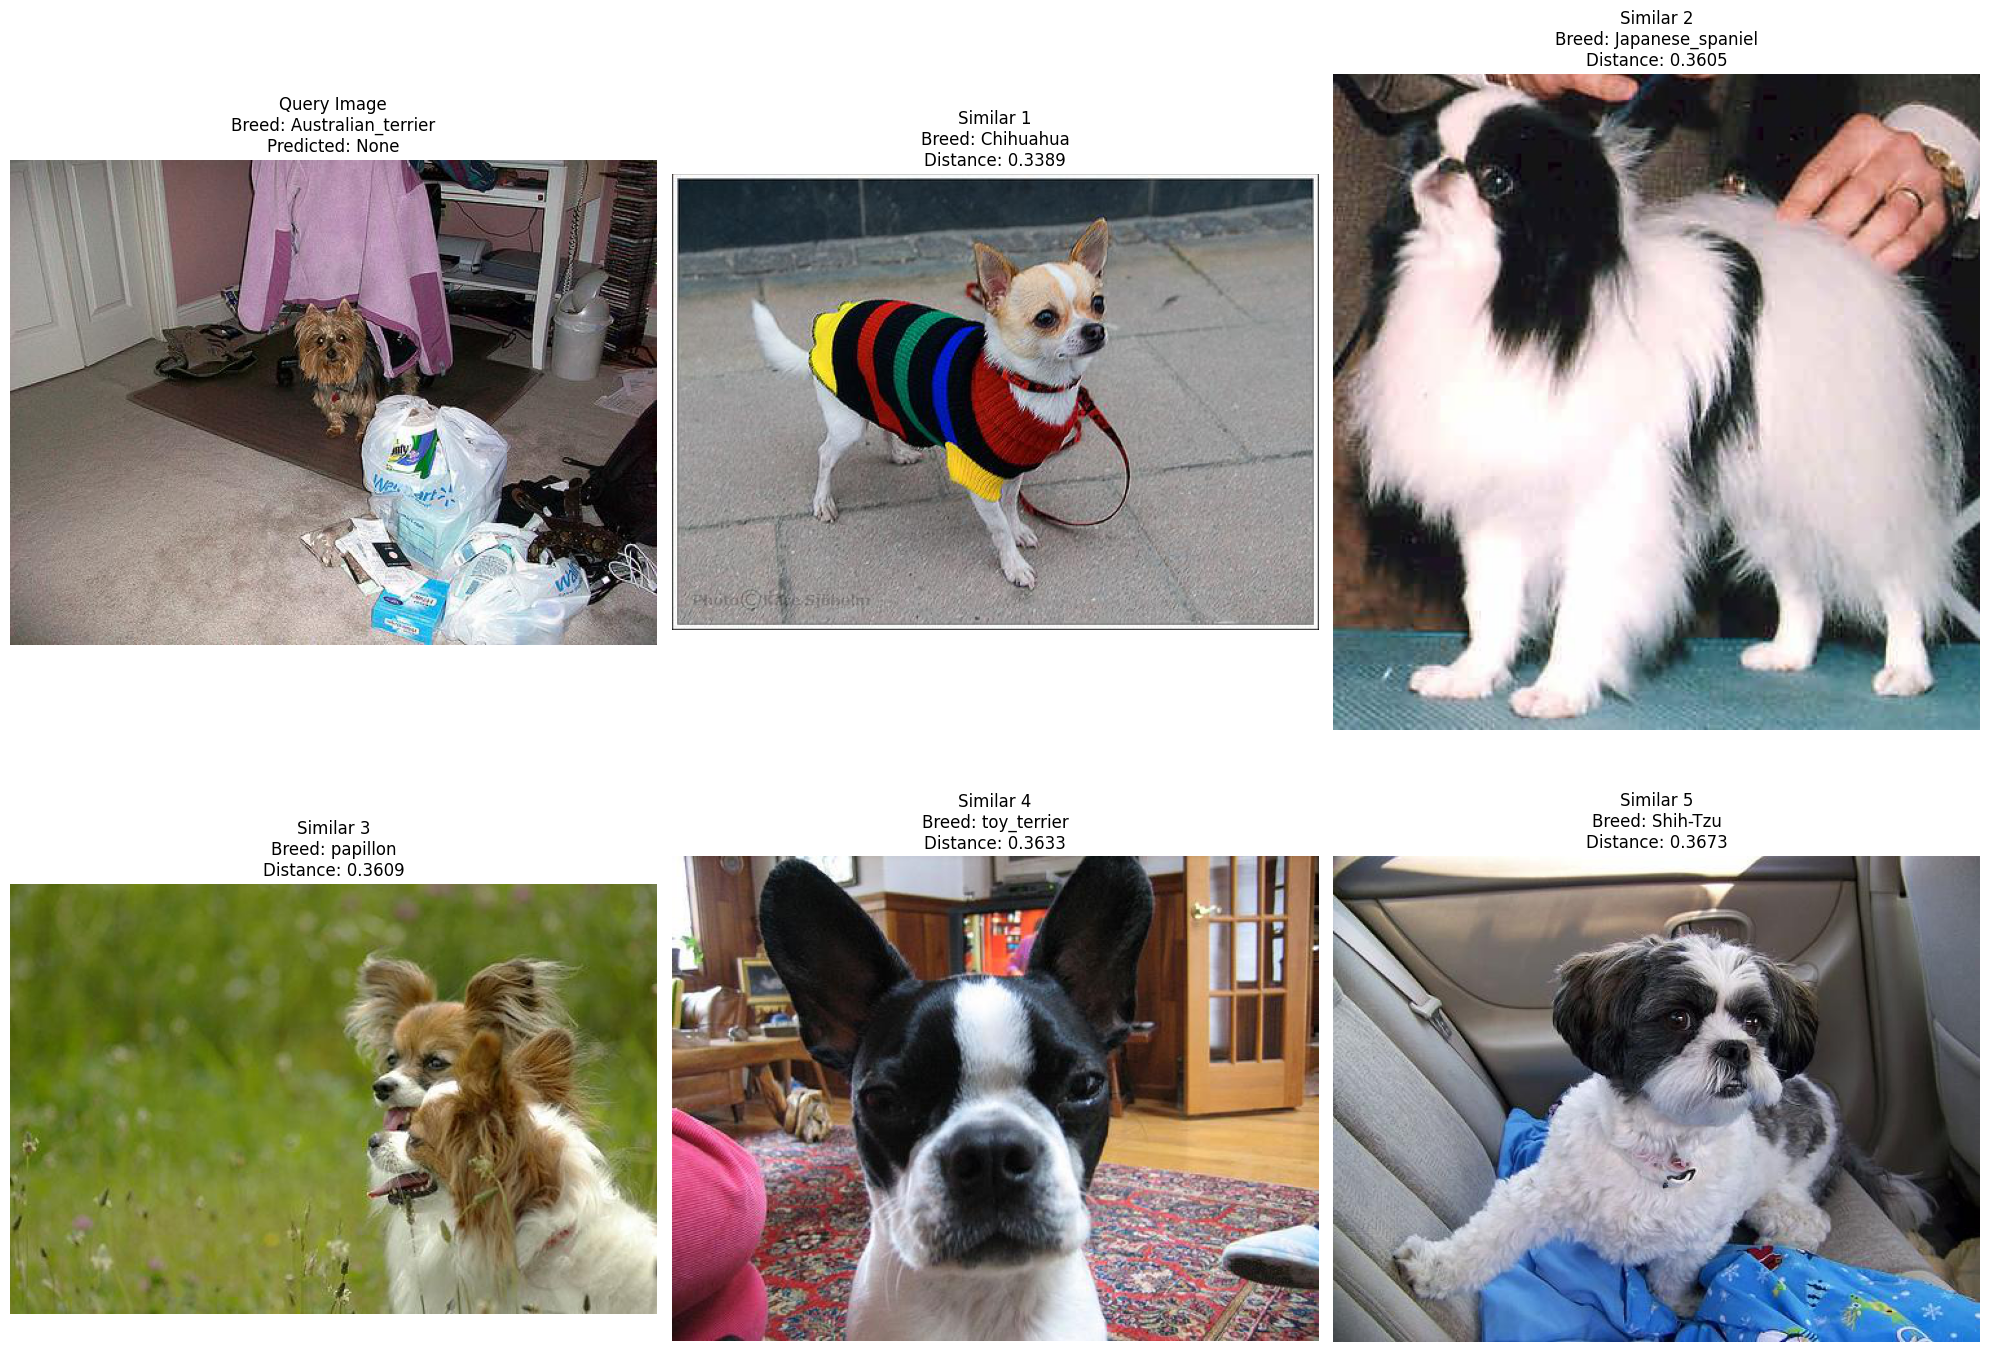

In [44]:
# Test the enhanced retrieval
test_image_idx = np.random.randint(0, len(all_image_paths))
test_image_path = all_image_paths[test_image_idx]
print(f"Query image: {test_image_path}")

# Try with and without breed filtering
similar_images, distances, predicted_breed = enhanced_retrieve_similar_images(
    test_image_path, X_test_pca, all_image_paths, top_k=5, breed_filtering=False)

# Display results
plt.figure(figsize=(20, 15))
plt.subplot(2, 3, 1)
query_img = mpimg.imread(test_image_path)
plt.imshow(query_img)
actual_breed = test_image_path.split('\\')[-2][10:] if '\\' in test_image_path else 'Unknown'
plt.title(f"Query Image\nBreed: {actual_breed}\nPredicted: {predicted_breed}")
plt.axis('off')

for i, (img_path, distance) in enumerate(zip(similar_images, distances)):
    plt.subplot(2, 3, i+2)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    retrieved_breed = img_path.split('\\')[-2][10:] if '\\' in img_path else 'Unknown'
    plt.title(f"Similar {i+1}\nBreed: {retrieved_breed}\nDistance: {distance:.4f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

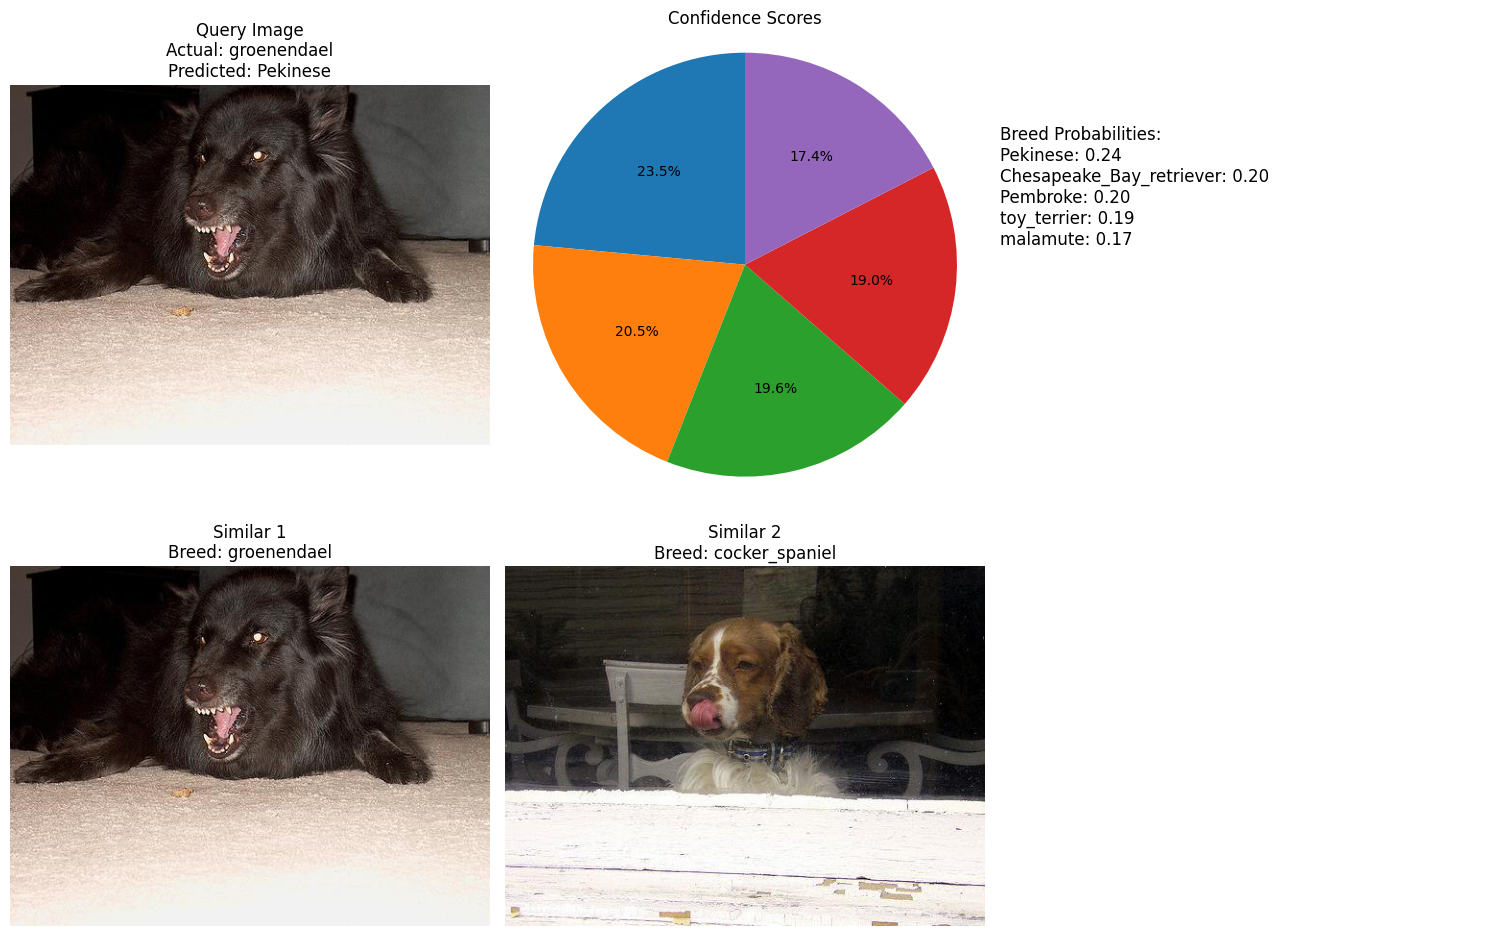

In [48]:
# Test the prediction function
sample_image_idx = np.random.randint(0, len(all_image_paths))
sample_image_path = all_image_paths[sample_image_idx]

predicted_breed, confidence_scores, similar_images = predict_dog_breed_with_confidence(sample_image_path)

# Display the results with a nice visualization
plt.figure(figsize=(15, 10))

# Query image
plt.subplot(2, 3, 1)
query_img = mpimg.imread(sample_image_path)
plt.imshow(query_img)
actual_breed = sample_image_path.split('\\')[-2][10:] if '\\' in sample_image_path else 'Unknown'
plt.title(f"Query Image\nActual: {actual_breed}\nPredicted: {predicted_breed}")
plt.axis('off')

# Confidence scores as pie chart
plt.subplot(2, 3, 2)
labels = list(confidence_scores.keys())
sizes = list(confidence_scores.values())
plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Confidence Scores')

# Legend for the pie chart
plt.subplot(2, 3, 3)
plt.axis('off')
legend_text = "Breed Probabilities:\n"
for breed, score in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
    legend_text += f"{breed}: {score:.2f}\n"
plt.text(0, 0.5, legend_text, fontsize=12)

# Show similar images
for i, img_path in enumerate(similar_images[:2]):
    plt.subplot(2, 3, i+4)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    similar_breed = img_path.split('\\')[-2][10:] if '\\' in img_path else 'Unknown'
    plt.title(f"Similar {i+1}\nBreed: {similar_breed}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Limitations

1. HOG features are a little sensitive to the scale of objects in images so dogs photographed at different distances may produce different feature vectors even for the same breed.

2. Our features extract information from the entire image, including backgrounds, which can introduce noise since the background doesn't contribute to breed identification.

3. Dogs photographed in different poses (sitting, standing, running) may produce significantly different feature vectors and reduce the overall accuracy of our classification.

### Potential Improvements

1. We could separate dogs from backgrounds before feature extraction so we'd only focud on relevant pixels.

2. We could extract features from specific body parts (head, body, tail). This may reduce the noise and be more informative for breed classification.


##### By Christine Dossa and Irene Luwabelwa